## Segmenting and Clustering Neighborhoods in UK

###### Import the necessary packages for the project

In [11]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.distance import great_circle
    
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as p

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

##!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans
import requests # library to handle requests
##import bs4  ##BeautifulSoup

print('Folium installed')
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Folium installed
Libraries imported.


## Functions Defined

In [12]:
def GeoDist(Origlat,Origlng,Destlat,Destlng):
    OrigLoc=(Origlat,Origlng)
    DestLoc=(Destlat,Destlng)
    DistCalc=great_circle(OrigLoc, DestLoc).miles
    return DistCalc

In [13]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
   ## Nearby Neighborhoods explored 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Distance',            
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Setup the New data source for use in the project

In [308]:
url="https://www.doogal.co.uk/PostcodeDistrictsCSV.ashx"

In [309]:
print(url)

https://www.doogal.co.uk/PostcodeDistrictsCSV.ashx


In [310]:
postcodeX = pd.read_csv(url)

### Description of the Postal code data 

In [311]:
postcodeX.describe()
##postcodeX.dtypes

print(postcodeX['Town/Area'].value_counts(),"\n\n")
print(postcodeX['Region'].value_counts())

Non-geographic                                  104
Isle Of Mull                                     13
Worcester                                        10
Isle Of Islay                                     8
Liverpool                                         7
                                               ... 
Cullingworth, Denholme, Queensbury, Thornton      1
Dudley town centre, Woodsetton                    1
Royston                                           1
Longton, Meir, Blurton, Weston Coyney             1
Thamesmead                                        1
Name: Town/Area, Length: 2799, dtype: int64 


Highland               85
Liverpool              52
Argyllshire            46
Cornwall               46
Birmingham             42
                       ..
Newcastle upon Tyne     1
Hertfordshire           1
Rothes                  1
Torridge                1
Ramsgate                1
Name: Region, Length: 428, dtype: int64


In [312]:
##postcodeX
postcodeX = postcodeX[["Postcode","Town/Area","Region","Latitude","Longitude","Nearby districts","Population"]]
postcodeXdf = pd.DataFrame(postcodeX)

In [313]:
print(postcodeXdf["Nearby districts"].describe())
print("\n The number of records in file are ",postcodeXdf.shape)

count                                                  3075
unique                                                 3075
top       YO12, YO11, YO14, YO22, YO18, YO25, YO21, YO17...
freq                                                      1
Name: Nearby districts, dtype: object

 The number of records in file are  (3114, 7)


### Setting up the environment for Foursquare.com data retrieval

In [314]:
UKpostcode_df= pd.DataFrame(postcodeXdf)
UKpostcode_df.dropna(inplace=True)

In [315]:
CLIENT_ID = 'JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO' # your Foursquare ID
CLIENT_SECRET = 'OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO
CLIENT_SECRET:OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG


### Focus of Hotels in Manchester
#### Pulling the data for Manchester and its venues around the proposed location

In [316]:
UKpostcode_df3= UKpostcode_df[UKpostcode_df["Region"].str.contains('Manchester')]

In [317]:
UKpostcode_df3.reset_index(drop=True, inplace=True)
UKpostcode_df3

,Postcode,Town/Area,Region,Latitude,Longitude,Nearby districts,Population
0,M1,"Piccadilly, Northern Quarter, Manchester City ...",Manchester,53.4777,-2.23681,"M2, M60, M4, M61, M99, M3, M15, M13, M8, M14",12340.0
1,M2,"Deansgate, Manchester City Centre",Manchester,53.4802,-2.24469,"M1, M3, M60, M4, M61, M99, M15, M8, M7, M5",88.0
2,M3,"Manchester City Centre, Blackfriars, Trinity",Manchester,53.4835,-2.25218,"M2, M15, M60, M1, M4, M61, M99, M7, M8, M5",11844.0
3,M4,"Ancoats, Northern Quarter, Strangeways",Manchester,53.4848,-2.23071,"M61, M60, M99, M1, M2, M3, M8, M13, M15, M14",10675.0
4,M8,"Crumpsall, Cheetham Hill",Manchester,53.5090,-2.24087,"M7, M60, M2, M61, M4, M99, M1, M3, M9, M10",30934.0
5,M9,"Harpurhey, Blackley",Manchester,53.5217,-2.21439,"M8, M10, M40, M24, M99, M61, M4, M60, M13, M7",39434.0
6,M11,"Clayton, Openshaw, Beswick",Manchester,53.4784,-2.18329,"M18, M40, M10, M12, M43, M35, M13, M19, M99, M4",20281.0
7,M12,"Ardwick, Longsight, Chorlton-on-Medlock",Manchester,53.4656,-2.20554,"M13, M52, M11, M18, M19, M14, M1, M99, M4, M61",16377.0
8,M13,"Ardwick, Longsight, Chorlton-on-Medlock",Manchester,53.4622,-2.21715,"M52, M12, M14, M1, M99, M4, M61, M60, M15, M18",23642.0
9,M14,"Fallowfield, Moss Side, Ladybarn, Rusholme",Manchester,53.4469,-2.22507,"M52, M13, M20, M12, M19, M1, M99, M4, M61, M60",53136.0


#### First Test - with a specific location from the various Locations

#### The location below will be used as the chosen location for this exercise

In [318]:
UKpostcode_df3.loc[0,'Town/Area']

'Piccadilly, Northern Quarter, Manchester City Centre'

#### Get the geo location of the proposed location

In [319]:
neighborhood_latitude = UKpostcode_df3.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = UKpostcode_df3.loc[0, 'Longitude'] # neighborhood longitude value

Manlat = neighborhood_latitude
Manlng = neighborhood_longitude 

neighborhood_name = UKpostcode_df3.loc[0, 'Town/Area'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Piccadilly, Northern Quarter, Manchester City Centre are 53.4777, -2.2368099999999997.


#### Connect to the FourSquare.com

In [320]:
LIMIT = 100
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO&client_secret=OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG&v=20180604&ll=53.4777,-2.2368099999999997&radius=500&limit=100'

#### Pull information about the different venues around the proposed Hotel Location

In [321]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee708a365fdfb234d93a3ea'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'City Centre',
  'headerFullLocation': 'City Centre, Manchester',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 147,
  'suggestedBounds': {'ne': {'lat': 53.4822000045, 'lng': -2.229262808394263},
   'sw': {'lat': 53.473199995499996, 'lng': -2.2443571916057365}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cbde546adcd5481cc5f36a2',
       'name': 'The Molly House',
       'location': {'address': '28 Richmond St',
        'lat': 53.47732477834979,
        'lng': -2.23720114426596,
        'labeledLatLngs': [{'label': 'display',
          'lat': 53.47

#### Extracting Venues information near First Location

In [322]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance','venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,distance,id
0,The Molly House,Pub,53.477325,-2.237201,49,4cbde546adcd5481cc5f36a2
1,Richmond Tea Rooms,Tea Room,53.477652,-2.236810,5,4e5a826452b1b78b81aaf8f6
2,No 1 Canal Street,Restaurant,53.478064,-2.235147,117,5999ac5c1c675b37230b7939
3,Habesha,Ethiopian Restaurant,53.477220,-2.237309,62,4bd204aa462cb713986adb07
4,Alan Turing Memorial Statue,Monument / Landmark,53.476690,-2.236049,123,4b15a7cff964a520e2b123e3


In [323]:
nearby_venues["rating"]=0
for  row,venue_id in nearby_venues[["id"]].iterrows():
    venue_id1 = nearby_venues["id"][row]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id1, CLIENT_ID, CLIENT_SECRET, VERSION)
    #print(url)
    resultVenue = requests.get(url).json()
    try:
        print(resultVenue['response']['venue']['rating'])
        nearby_venues["rating"][row] = resultVenue['response']['venue']['rating']
    except:
        print('This venue has not been rated yet.')

This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not been rated yet.
This venue has not b

In [324]:
nearby_venues

,name,categories,lat,lng,distance,id,rating
0,The Molly House,Pub,53.477325,-2.237201,49,4cbde546adcd5481cc5f36a2,0
1,Richmond Tea Rooms,Tea Room,53.477652,-2.236810,5,4e5a826452b1b78b81aaf8f6,0
2,No 1 Canal Street,Restaurant,53.478064,-2.235147,117,5999ac5c1c675b37230b7939,0
3,Habesha,Ethiopian Restaurant,53.477220,-2.237309,62,4bd204aa462cb713986adb07,0
4,Alan Turing Memorial Statue,Monument / Landmark,53.476690,-2.236049,123,4b15a7cff964a520e2b123e3,0
...,...,...,...,...,...,...,...
95,Archie's,Burger Joint,53.474292,-2.240874,465,4c172b376470a593a5f457d2,0
96,Philpotts,Sandwich Place,53.476133,-2.242375,407,4b56f47ef964a5208a2028e3,0
97,Fumo,Italian Restaurant,53.477416,-2.243536,446,5485f291498ee0762e8f7b3e,0
98,Pret A Manger,Sandwich Place,53.477580,-2.231088,379,4ee36532e4b059cb7703d5a8,0


In [325]:
print('{} venues in Manchester were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues in Manchester were returned by Foursquare.


### Looking for how many hotels and other attractions within that location

In [327]:
nearby_hotel=nearby_venues[nearby_venues["categories"].str.contains('Hotel')]
hotel_lat=nearby_venues["lat"][0]
hotel_lng=nearby_venues["lng"][0]

ManNearby=nearby_hotel
nearby_hotel
print("Other locations apart for Hotels - Venues :\n", nearby_venues["categories"].value_counts(),"\n")

Other locations apart for Hotels - Venues :
 Gay Bar                       12
Hotel                         11
Coffee Shop                    7
Bar                            4
Pub                            4
Indian Restaurant              4
Plaza                          3
Cocktail Bar                   3
Sushi Restaurant               3
Sandwich Place                 2
Art Gallery                    2
Japanese Restaurant            2
Italian Restaurant             2
Burger Joint                   2
Chinese Restaurant             2
Bakery                         2
Fast Food Restaurant           2
Burrito Place                  2
Restaurant                     2
Beer Bar                       2
Park                           1
Thai Restaurant                1
Fish & Chips Shop              1
Adult Boutique                 1
Tea Room                       1
Theater                        1
Monument / Landmark            1
Portuguese Restaurant          1
Juice Bar                      

In [330]:
df_pie1 = nearby_venues.groupby('categories', axis=0).count()

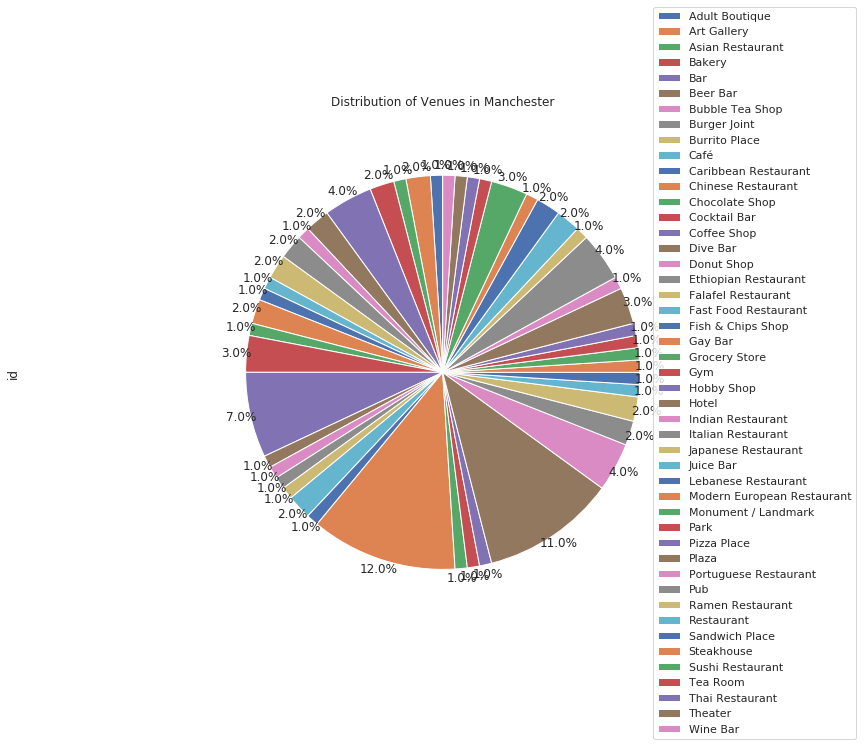

In [331]:
df_pie1['id'].plot(kind='pie',
                            figsize=(15, 8),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=False,       # add shadow  
                             labels=None, 
                           pctdistance=1.05
                            )
p.title('Distribution of Venues in Manchester', y=1.1)
p.axis('equal') # Sets the pie chart to look like a circle.
p.legend(labels=df_pie1.index, loc='right') 
p.show()

#### The mean distance of Hotels to the proposed location

In [332]:
## Non Hotel venues
nearby_nothotel=nearby_venues[ (nearby_venues["categories"].str.contains('Hotel'))==False]
nearby_nothotel

## Hotel Details
print("Hotel Venues (in competition) :\n", nearby_hotel["categories"].value_counts(),"\n")
print('{} Hotel venues were returned by Foursquare for the Manchester location({},{}) .'.format(nearby_hotel.shape[0],round(hotel_lat,2),round(hotel_lng,2)))
print("\n\n Mean distance of existing Hotels to the proposed location: ", nearby_hotel.groupby('categories').mean())
print("\n\n Minimum distance from the nearest Hotel to the proposed location: ", nearby_hotel.groupby('categories').min())

Hotel Venues (in competition) :
 Hotel    11
Name: categories, dtype: int64 

11 Hotel venues were returned by Foursquare for the Manchester location(53.48,-2.24) .


 Mean distance of existing Hotels to the proposed location:                    lat      lng    distance  rating
categories                                        
Hotel       53.477852 -2.23731  288.727273     0.0


 Minimum distance from the nearest Hotel to the proposed location:                                                 name        lat       lng  \
categories                                                                 
Hotel       Atrium By Bridgestreet Hotel Manchester  53.475248 -2.242235   

            distance                        id  rating  
categories                                              
Hotel             75  4ade0ddaf964a5206f6d21e3       0  


In [334]:
nearby_nothotel

,name,categories,lat,lng,distance,id,rating
0,The Molly House,Pub,53.477325,-2.237201,49,4cbde546adcd5481cc5f36a2,0
1,Richmond Tea Rooms,Tea Room,53.477652,-2.236810,5,4e5a826452b1b78b81aaf8f6,0
2,No 1 Canal Street,Restaurant,53.478064,-2.235147,117,5999ac5c1c675b37230b7939,0
3,Habesha,Ethiopian Restaurant,53.477220,-2.237309,62,4bd204aa462cb713986adb07,0
4,Alan Turing Memorial Statue,Monument / Landmark,53.476690,-2.236049,123,4b15a7cff964a520e2b123e3,0
...,...,...,...,...,...,...,...
95,Archie's,Burger Joint,53.474292,-2.240874,465,4c172b376470a593a5f457d2,0
96,Philpotts,Sandwich Place,53.476133,-2.242375,407,4b56f47ef964a5208a2028e3,0
97,Fumo,Italian Restaurant,53.477416,-2.243536,446,5485f291498ee0762e8f7b3e,0
98,Pret A Manger,Sandwich Place,53.477580,-2.231088,379,4ee36532e4b059cb7703d5a8,0


### Create boxplots for the Hotels distribution

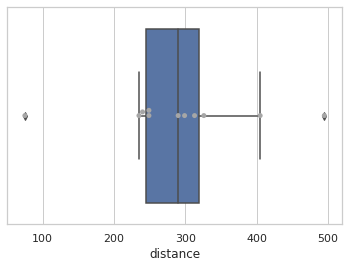

In [335]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=nearby_hotel["distance"])
ax = sns.swarmplot(x=nearby_hotel["distance"], color=".65")

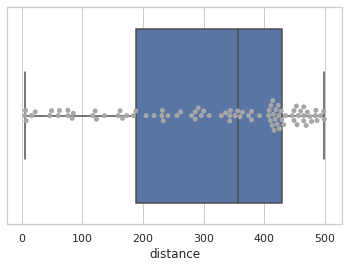

In [336]:
ax = sns.boxplot(x=nearby_nothotel["distance"])
ax = sns.swarmplot(x=nearby_nothotel["distance"], color=".65")

In [337]:
# create map of UK using latitude and longitude values
map_city= folium.Map(location=[hotel_lat, hotel_lng], zoom_start=15)

# add markers to map
for lat, lng,town, cat,dist in zip(nearby_hotel['lat'], nearby_hotel['lng'],nearby_hotel['name'], nearby_hotel['categories'], nearby_hotel['distance']):
    label = '{},{},{}'.format(cat,town,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city) 
    
## Others facilities Location
for lat, lng,town, cat,dist in zip(nearby_nothotel['lat'], nearby_nothotel['lng'],nearby_nothotel['name'], nearby_nothotel['categories'], nearby_nothotel['distance']):
    label = '{},{},{}'.format(cat,town,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city) 

## Planned Hotel Location
folium.CircleMarker(
    [hotel_lat, hotel_lng],
    radius=5,
    popup='Planned Hotel',
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_city)  
    
map_city

## Nearby Neighborhoods explored

In [220]:
Location1_venues = getNearbyVenues(names=UKpostcode_df3['Town/Area'],
                                   latitudes=UKpostcode_df3['Latitude'],
                                   longitudes=UKpostcode_df3['Longitude']
                                  )
Location1_venues

Piccadilly, Northern Quarter, Manchester City Centre
Deansgate, Manchester City Centre
Manchester City Centre, Blackfriars, Trinity
Ancoats, Northern Quarter, Strangeways
Crumpsall, Cheetham Hill
Harpurhey, Blackley
Clayton, Openshaw, Beswick
Ardwick, Longsight, Chorlton-on-Medlock
Ardwick, Longsight, Chorlton-on-Medlock
Fallowfield, Moss Side, Ladybarn, Rusholme
Hulme, Manchester Science Park
Abbey Hey, Gorton
Levenshulme, Burnage
Didsbury, Withington
Chorlton-cum-Hardy, Firswood
Wythenshawe, Northenden, Sharston Industrial Area
Baguley, Roundthorn Industrial Estate
Collyhurst, Miles Platting, Moston, New Moston, Newton Heath
Large user and PO Box


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category
0,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,The Molly House,53.477325,-2.237201,49,Pub
1,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,Richmond Tea Rooms,53.477652,-2.236810,5,Tea Room
2,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,No 1 Canal Street,53.478064,-2.235147,117,Restaurant
3,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,Habesha,53.477220,-2.237309,62,Ethiopian Restaurant
4,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,Alan Turing Memorial Statue,53.476690,-2.236049,123,Monument / Landmark
...,...,...,...,...,...,...,...,...
449,Large user and PO Box,53.4847,-2.23313,High Street Tavern,53.483743,-2.238689,383,Bar
450,Large user and PO Box,53.4847,-2.23313,Piccadilly Gardens,53.480934,-2.236941,489,Plaza
451,Large user and PO Box,53.4847,-2.23313,Nando's,53.483621,-2.240325,491,Portuguese Restaurant
452,Large user and PO Box,53.4847,-2.23313,Starbucks,53.481841,-2.238139,459,Coffee Shop


In [118]:
print("The number of of locations", Location1_venues.shape[0])

The number of of locations 454


In [230]:
ManNeighHotels=Location1_venues[Location1_venues["Venue Category"].str.contains('Hotel')==True]
print("The number hotel in Neighboring locations: ",ManNeighHotels.shape[0], " Percentage is ", round(ManNeighHotels.shape[0]/Location1_venues.shape[0]*100,2),"%")

The number hotel in Neighboring locations:  24  Percentage is  5.29 %


In [231]:
Location1_venues["GeoDistNV"]=0.00
Location1_venues["GeoDistVH"]=0.00

result11=[]
result12=[]

for label, row in Location1_venues.iterrows():
    OrigLat = row['Neighborhood Latitude']
    OrigLng = row['Neighborhood Longitude']
    DestLat = row['Venue Latitude']
    DestLng = row['Venue Longitude']
    Getdist = round(GeoDist(OrigLat, OrigLng ,DestLat,DestLng),2)
    result11.append(Getdist)
    Getdist = round(GeoDist(neighborhood_latitude, neighborhood_longitude ,DestLat,DestLng),2)
    result12.append(Getdist)

In [232]:
Location1_venues.drop('GeoDistNV', 1)
Location1_venues.drop('GeoDistVH', 1)

Location1_venues['GeoDistNV'] = result11
Location1_venues['GeoDistVH'] = result12

In [233]:
Location1_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category,GeoDistNV,GeoDistVH
0,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,The Molly House,53.477325,-2.237201,49,Pub,0.03,0.03
1,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,Richmond Tea Rooms,53.477652,-2.236810,5,Tea Room,0.00,0.00
2,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,No 1 Canal Street,53.478064,-2.235147,117,Restaurant,0.07,0.07
3,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,Habesha,53.477220,-2.237309,62,Ethiopian Restaurant,0.04,0.04
4,"Piccadilly, Northern Quarter, Manchester City ...",53.4777,-2.23681,Alan Turing Memorial Statue,53.476690,-2.236049,123,Monument / Landmark,0.08,0.08
...,...,...,...,...,...,...,...,...,...,...
449,Large user and PO Box,53.4847,-2.23313,High Street Tavern,53.483743,-2.238689,383,Bar,0.24,0.42
450,Large user and PO Box,53.4847,-2.23313,Piccadilly Gardens,53.480934,-2.236941,489,Plaza,0.30,0.22
451,Large user and PO Box,53.4847,-2.23313,Nando's,53.483621,-2.240325,491,Portuguese Restaurant,0.31,0.43
452,Large user and PO Box,53.4847,-2.23313,Starbucks,53.481841,-2.238139,459,Coffee Shop,0.29,0.29


In [234]:
Location1_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category,GeoDistNV,GeoDistVH
Neighborhood,,,,,,,,,
"Abbey Hey, Gorton",6,6,6,6,6,6,6,6,6
"Ancoats, Northern Quarter, Strangeways",52,52,52,52,52,52,52,52,52
"Ardwick, Longsight, Chorlton-on-Medlock",11,11,11,11,11,11,11,11,11
"Baguley, Roundthorn Industrial Estate",4,4,4,4,4,4,4,4,4
"Chorlton-cum-Hardy, Firswood",39,39,39,39,39,39,39,39,39
"Clayton, Openshaw, Beswick",1,1,1,1,1,1,1,1,1
"Collyhurst, Miles Platting, Moston, New Moston, Newton Heath",2,2,2,2,2,2,2,2,2
"Crumpsall, Cheetham Hill",6,6,6,6,6,6,6,6,6
"Deansgate, Manchester City Centre",75,75,75,75,75,75,75,75,75


In [235]:
Location1_venues.groupby('Venue Category').mean()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,GeoDistNV,GeoDistVH
Venue Category,,,,,,,
Adult Boutique,53.477700,-2.236810,53.477182,-2.237569,76.000000,0.050000,0.050000
Art Gallery,53.481020,-2.236430,53.481028,-2.239274,303.000000,0.188000,0.300000
Arts & Crafts Store,53.484750,-2.231920,53.483440,-2.234778,266.750000,0.165000,0.405000
Asian Restaurant,53.488967,-2.240790,53.489013,-2.242280,239.666667,0.150000,0.893333
Australian Restaurant,53.481850,-2.248435,53.480038,-2.248783,358.500000,0.225000,0.520000
...,...,...,...,...,...,...,...
Tram Station,53.440917,-2.243700,53.441706,-2.242876,389.666667,0.241667,3.988333
Turkish Restaurant,53.459500,-2.259045,53.459385,-2.258111,437.000000,0.270000,1.550000
Vegetarian / Vegan Restaurant,53.478533,-2.238763,53.479297,-2.241903,312.333333,0.193333,0.610000


In [236]:
print('There are {} uniques categories.'.format(len(Location1_venues['Venue Category'].unique())))

There are 103 uniques categories.


In [237]:
Location1_venues.groupby('Neighborhood').mean()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,GeoDistNV,GeoDistVH
Neighborhood,,,,,,,
"Abbey Hey, Gorton",53.461600,-2.172800,53.462376,-2.173712,155.000000,0.095000,2.803333
"Ancoats, Northern Quarter, Strangeways",53.484800,-2.230710,53.483574,-2.233049,324.557692,0.201154,0.452885
"Ardwick, Longsight, Chorlton-on-Medlock",53.463436,-2.212928,53.464289,-2.214466,366.727273,0.227273,1.346364
"Baguley, Roundthorn Industrial Estate",53.397100,-2.286570,53.398172,-2.285081,334.750000,0.207500,5.842500
"Chorlton-cum-Hardy, Firswood",53.438800,-2.273400,53.439546,-2.275512,322.794872,0.200513,3.082308
"Clayton, Openshaw, Beswick",53.478400,-2.183290,53.482384,-2.184344,448.000000,0.280000,2.180000
"Collyhurst, Miles Platting, Moston, New Moston, Newton Heath",53.502800,-2.193740,53.501683,-2.197145,265.500000,0.165000,2.325000
"Crumpsall, Cheetham Hill",53.509000,-2.240870,53.508892,-2.240079,188.666667,0.118333,2.160000
"Deansgate, Manchester City Centre",53.480200,-2.244690,53.479249,-2.245074,344.400000,0.214267,0.388533


### Analysis of Each Neighborhood

#### One hot encoding

In [238]:
Location1_onehot = pd.get_dummies(Location1_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Location1_onehot['Neighborhood'] = Location1_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Location1_onehot.columns[-1]] + list(Location1_onehot.columns[:-1])
Location1_onehot = Location1_onehot[fixed_columns]

Location1_onehot.head()

,Neighborhood,Adult Boutique,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,Bakery,Bar,Beer Bar,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Yoga Studio
0,"Piccadilly, Northern Quarter, Manchester City ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Piccadilly, Northern Quarter, Manchester City ...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"Piccadilly, Northern Quarter, Manchester City ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Piccadilly, Northern Quarter, Manchester City ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Piccadilly, Northern Quarter, Manchester City ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [239]:
Location1_onehot.shape[0]

454

#### Data grouped & the mean obtained for the different venues

In [240]:
Location1_grouped = Location1_onehot.groupby('Neighborhood').mean().reset_index()
Location1_grouped

,Neighborhood,Adult Boutique,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,Bakery,Bar,Beer Bar,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Yoga Studio
0,"Abbey Hey, Gorton",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Ancoats, Northern Quarter, Strangeways",0.00,0.019231,0.038462,0.000000,0.000000,0.00,0.019231,0.076923,0.038462,...,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000
2,"Ardwick, Longsight, Chorlton-on-Medlock",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Baguley, Roundthorn Industrial Estate",0.00,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Chorlton-cum-Hardy, Firswood",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.153846,0.000000,...,0.025641,0.025641,0.000000,0.025641,0.000000,0.025641,0.025641,0.000000,0.000000,0.025641
5,"Clayton, Openshaw, Beswick",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Collyhurst, Miles Platting, Moston, New Moston...",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
7,"Crumpsall, Cheetham Hill",0.00,0.000000,0.000000,0.166667,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
8,"Deansgate, Manchester City Centre",0.00,0.013333,0.000000,0.013333,0.013333,0.00,0.000000,0.066667,0.013333,...,0.013333,0.000000,0.000000,0.026667,0.013333,0.000000,0.013333,0.000000,0.026667,0.000000
9,"Didsbury, Withington",0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.083333,0.083333,0.000000,0.083333,0.000000,0.000000,0.083333,0.000000


#### Top 5 venues in the different Neighborhood extracted & listed below:

In [241]:
num_top_venues = 5

for hood in Location1_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Location1_grouped[Location1_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Hey, Gorton----
            venue  freq
0     Supermarket  0.17
1  Gymnastics Gym  0.17
2          Bakery  0.17
3          Market  0.17
4  Sandwich Place  0.17


----Ancoats, Northern Quarter, Strangeways----
         venue  freq
0  Coffee Shop  0.13
1          Bar  0.08
2          Pub  0.08
3     Tea Room  0.06
4  Record Shop  0.06


----Ardwick, Longsight, Chorlton-on-Medlock----
               venue  freq
0     Sandwich Place  0.18
1        Sports Club  0.18
2           Bus Stop  0.18
3  Electronics Store  0.09
4  Korean Restaurant  0.09


----Baguley, Roundthorn Industrial Estate----
                  venue  freq
0                  Park  0.50
1       Automotive Shop  0.25
2  Fast Food Restaurant  0.25
3        Adult Boutique  0.00
4           Music Venue  0.00


----Chorlton-cum-Hardy, Firswood----
           venue  freq
0            Bar  0.15
1    Pizza Place  0.05
2           Café  0.05
3     Restaurant  0.05
4  Grocery Store  0.05


----Clayton, Openshaw, Beswick----
 

#### The 10 most common venues are listed and imported into a dataframe.

####   10 most common venues & New Dataframe

In [242]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Location1_grouped['Neighborhood']

for ind in np.arange(Location1_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Location1_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbey Hey, Gorton",Fast Food Restaurant,Gymnastics Gym,Bakery,Sandwich Place,Supermarket,Market,Yoga Studio,Deli / Bodega,Department Store,Dive Bar
1,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Bar,Pub,Record Shop,Tea Room,Beer Bar,Arts & Crafts Store,Pizza Place,Cocktail Bar,Concert Hall
2,"Ardwick, Longsight, Chorlton-on-Medlock",Sports Club,Sandwich Place,Bus Stop,Pharmacy,Climbing Gym,Chinese Restaurant,Korean Restaurant,Electronics Store,Cosmetics Shop,Deli / Bodega
3,"Baguley, Roundthorn Industrial Estate",Park,Automotive Shop,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store
4,"Chorlton-cum-Hardy, Firswood",Bar,Pizza Place,Restaurant,Grocery Store,Indian Restaurant,Café,Yoga Studio,Japanese Restaurant,Pub,Bus Station


In [264]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Location1_grouped['Neighborhood']

for ind in np.arange(Location1_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Location1_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbey Hey, Gorton",Fast Food Restaurant,Gymnastics Gym,Bakery,Sandwich Place,Supermarket,Market,Yoga Studio,Deli / Bodega,Department Store,Dive Bar
1,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Bar,Pub,Record Shop,Tea Room,Beer Bar,Arts & Crafts Store,Pizza Place,Cocktail Bar,Concert Hall
2,"Ardwick, Longsight, Chorlton-on-Medlock",Sports Club,Sandwich Place,Bus Stop,Pharmacy,Climbing Gym,Chinese Restaurant,Korean Restaurant,Electronics Store,Cosmetics Shop,Deli / Bodega
3,"Baguley, Roundthorn Industrial Estate",Park,Automotive Shop,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store
4,"Chorlton-cum-Hardy, Firswood",Bar,Pizza Place,Restaurant,Grocery Store,Indian Restaurant,Café,Yoga Studio,Japanese Restaurant,Pub,Bus Station


In [265]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbey Hey, Gorton",Fast Food Restaurant,Gymnastics Gym,Bakery,Sandwich Place,Supermarket,Market,Yoga Studio,Deli / Bodega,Department Store,Dive Bar
1,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Bar,Pub,Record Shop,Tea Room,Beer Bar,Arts & Crafts Store,Pizza Place,Cocktail Bar,Concert Hall
2,"Ardwick, Longsight, Chorlton-on-Medlock",Sports Club,Sandwich Place,Bus Stop,Pharmacy,Climbing Gym,Chinese Restaurant,Korean Restaurant,Electronics Store,Cosmetics Shop,Deli / Bodega
3,"Baguley, Roundthorn Industrial Estate",Park,Automotive Shop,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store
4,"Chorlton-cum-Hardy, Firswood",Bar,Pizza Place,Restaurant,Grocery Store,Indian Restaurant,Café,Yoga Studio,Japanese Restaurant,Pub,Bus Station
5,"Clayton, Openshaw, Beswick",Pub,Yoga Studio,Concert Hall,Cosmetics Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store,English Restaurant
6,"Collyhurst, Miles Platting, Moston, New Moston...",Tram Station,Café,Yoga Studio,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store
7,"Crumpsall, Cheetham Hill",Burger Joint,Tram Station,Asian Restaurant,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Yoga Studio,Deli / Bodega,Department Store,Dive Bar
8,"Deansgate, Manchester City Centre",Hotel,Coffee Shop,Bar,Italian Restaurant,Sandwich Place,Plaza,Café,Bookstore,Thai Restaurant,Wine Bar
9,"Didsbury, Withington",Pizza Place,Café,Deli / Bodega,Wine Bar,Tram Station,Gym / Fitness Center,Thai Restaurant,Tennis Court,Bus Station,Bus Stop


## 4. Cluster Neighborhoods
#### Using Kmeans to identify the different clusters

In [266]:
# set number of clusters
kclusters = 5

Location1_grouped_clustering = Location1_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Location1_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 1, 1, 3, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [267]:
Location1_grouped_clustering

,Adult Boutique,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,Automotive Shop,Bakery,Bar,Beer Bar,Beer Store,...,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Yoga Studio
0,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.019231,0.038462,0.000000,0.000000,0.00,0.019231,0.076923,0.038462,0.019231,...,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.000000
2,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.153846,0.000000,0.000000,...,0.025641,0.025641,0.000000,0.025641,0.000000,0.025641,0.025641,0.000000,0.000000,0.025641
5,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.000000,0.000000,0.166667,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
8,0.00,0.013333,0.000000,0.013333,0.013333,0.00,0.000000,0.066667,0.013333,0.000000,...,0.013333,0.000000,0.000000,0.026667,0.013333,0.000000,0.013333,0.000000,0.026667,0.000000
9,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.083333,0.083333,0.000000,0.083333,0.000000,0.000000,0.083333,0.000000


In [268]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abbey Hey, Gorton",Fast Food Restaurant,Gymnastics Gym,Bakery,Sandwich Place,Supermarket,Market,Yoga Studio,Deli / Bodega,Department Store,Dive Bar
1,"Ancoats, Northern Quarter, Strangeways",Coffee Shop,Bar,Pub,Record Shop,Tea Room,Beer Bar,Arts & Crafts Store,Pizza Place,Cocktail Bar,Concert Hall
2,"Ardwick, Longsight, Chorlton-on-Medlock",Sports Club,Sandwich Place,Bus Stop,Pharmacy,Climbing Gym,Chinese Restaurant,Korean Restaurant,Electronics Store,Cosmetics Shop,Deli / Bodega
3,"Baguley, Roundthorn Industrial Estate",Park,Automotive Shop,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store
4,"Chorlton-cum-Hardy, Firswood",Bar,Pizza Place,Restaurant,Grocery Store,Indian Restaurant,Café,Yoga Studio,Japanese Restaurant,Pub,Bus Station
5,"Clayton, Openshaw, Beswick",Pub,Yoga Studio,Concert Hall,Cosmetics Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store,English Restaurant
6,"Collyhurst, Miles Platting, Moston, New Moston...",Tram Station,Café,Yoga Studio,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dive Bar,Donut Shop,Electronics Store
7,"Crumpsall, Cheetham Hill",Burger Joint,Tram Station,Asian Restaurant,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Yoga Studio,Deli / Bodega,Department Store,Dive Bar
8,"Deansgate, Manchester City Centre",Hotel,Coffee Shop,Bar,Italian Restaurant,Sandwich Place,Plaza,Café,Bookstore,Thai Restaurant,Wine Bar
9,"Didsbury, Withington",Pizza Place,Café,Deli / Bodega,Wine Bar,Tram Station,Gym / Fitness Center,Thai Restaurant,Tennis Court,Bus Station,Bus Stop


In [269]:
UKpostcode_df3_2=UKpostcode_df3
UKpostcode_df3_2.rename(columns={'Town/Area':'Neighborhood'}, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [270]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Location1_merged = UKpostcode_df3_2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Location1_merged = Location1_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Location1_merged.head() # check the last columns!

,Postcode,Neighborhood,Region,Latitude,Longitude,Nearby districts,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1,"Piccadilly, Northern Quarter, Manchester City ...",Manchester,53.4777,-2.23681,"M2, M60, M4, M61, M99, M3, M15, M13, M8, M14",12340.0,1,Gay Bar,Hotel,Coffee Shop,Pub,Bar,Indian Restaurant,Plaza,Cocktail Bar,Sushi Restaurant,Fast Food Restaurant
1,M2,"Deansgate, Manchester City Centre",Manchester,53.4802,-2.24469,"M1, M3, M60, M4, M61, M99, M15, M8, M7, M5",88.0,1,Hotel,Coffee Shop,Bar,Italian Restaurant,Sandwich Place,Plaza,Café,Bookstore,Thai Restaurant,Wine Bar
2,M3,"Manchester City Centre, Blackfriars, Trinity",Manchester,53.4835,-2.25218,"M2, M15, M60, M1, M4, M61, M99, M7, M8, M5",11844.0,1,Coffee Shop,Bar,Hotel,Plaza,Pub,Restaurant,Café,Sandwich Place,Italian Restaurant,Indian Restaurant
3,M4,"Ancoats, Northern Quarter, Strangeways",Manchester,53.4848,-2.23071,"M61, M60, M99, M1, M2, M3, M8, M13, M15, M14",10675.0,1,Coffee Shop,Bar,Pub,Record Shop,Tea Room,Beer Bar,Arts & Crafts Store,Pizza Place,Cocktail Bar,Concert Hall
4,M8,"Crumpsall, Cheetham Hill",Manchester,53.5090,-2.24087,"M7, M60, M2, M61, M4, M99, M1, M3, M9, M10",30934.0,1,Burger Joint,Tram Station,Asian Restaurant,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Yoga Studio,Deli / Bodega,Department Store,Dive Bar


In [271]:
import math
# create map
latitude=Location1_merged['Latitude'][0]
longitude=Location1_merged['Longitude'][0]

map_Location1_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Location1_merged['Latitude'], Location1_merged['Longitude'], Location1_merged['Neighborhood'], Location1_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if  not math.isnan(cluster):
        icluster=int(cluster)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            ##color=rainbow[cluster-1],
            color=rainbow[icluster-1],
            fill=True,
            ##fill_color=rainbow[cluster-1],
            fill_color=rainbow[icluster-1],
            fill_opacity=0.7).add_to(map_Location1_clusters)

        ## Planned Hotel Location
folium.CircleMarker(
    [hotel_lat, hotel_lng],
    radius=5,
    popup='Planned Hotel',
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_Location1_clusters) 
map_Location1_clusters

## Second Location - with a specific location in London from the various Locations there.

In [284]:
UKpostcode_df2= UKpostcode_df[UKpostcode_df["Region"].str.contains('City of London')]
UKpostcode_df2.reset_index(drop=True, inplace=True)
UKpostcode_df2

,Postcode,Town/Area,Region,Latitude,Longitude,Nearby districts,Population
0,EC1A,St Bartholomew's Hospital,City of London,51.5203,-0.104446,"EC1M, EC3P, EC1N, EC2Y, EC4A, EC1R, EC4P, EC4M...",878.0
1,EC2M,"Broadgate, Liverpool Street",City of London,51.5184,-0.086829,"EC2N, EC3V, EC2A, EC2R, EC3A, EC3M, EC3R, EC3B...",99.0
2,EC2N,"Old Broad Street, Tower 42",City of London,51.5160,-0.087486,"EC2M, EC3V, EC2R, EC3A, EC3M, EC2V, EC3R, EC3B...",5.0
3,EC2R,Bank of England,City of London,51.5163,-0.091867,"EC2V, EC4N, EC2N, EC4R, EC2M, EC3V, EC2Y, EC1Y...",13.0
4,EC2V,Guildhall,City of London,51.5158,-0.094928,"EC2R, EC4N, EC2Y, EC4M, EC4R, EC2N, EC4V, EC1Y...",24.0
5,EC2Y,Barbican,City of London,51.5200,-0.096344,"EC2V, EC1Y, EC2R, EC1A, EC1M, EC4M, EC1V, EC4N...",3155.0
6,EC3A,"St Mary Axe, Aldgate",City of London,51.5150,-0.082009,"EC3B, EC3M, EC3N, EC3R, EC2N, EC3V, EC2M, EC2R...",44.0
7,EC3M,"Leadenhall, Lloyd's of London, Fenchurch Street",City of London,51.5122,-0.083735,"EC3R, EC3B, EC3V, EC3N, EC3A, EC2N, EC4R, EC2M...",6.0
8,EC3R,"Monument, Billingsgate",City of London,51.5112,-0.084651,"EC3M, EC3V, EC3B, EC3N, EC3A, EC4R, EC2N, EC2M...",98.0
9,EC3V,"Royal Exchange, Lombard Street",City of London,51.5133,-0.086911,"EC2N, EC3M, EC3R, EC2M, EC3B, EC4N, EC3A, EC4R...",16.0


In [287]:
UKpostcode_df2.loc[0,'Town/Area']

"St Bartholomew's Hospital"

In [288]:
neighborhood_latitude = UKpostcode_df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = UKpostcode_df2.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = UKpostcode_df2.loc[0, 'Town/Area'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of St Bartholomew's Hospital are 51.5203, -0.104446.


In [289]:
LIMIT = 100
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO&client_secret=OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG&v=20180604&ll=51.5203,-0.104446&radius=500&limit=100'

In [290]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee703c0a5f59c7599796230'},
 'response': {'headerLocation': 'Clerkenwell',
  'headerFullLocation': 'Clerkenwell, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 55,
  'suggestedBounds': {'ne': {'lat': 51.5248000045,
    'lng': -0.09722752829105799},
   'sw': {'lat': 51.5157999955, 'lng': -0.111664471708942}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '564cfa5a38fa39dab7e3efcb',
       'name': 'Oriole',
       'location': {'address': 'East Poultry Ave',
        'lat': 51.51890435770055,
        'lng': -0.10267230860740448,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.51890435770055,
          'lng': -0.10267230860740448}],
        'distance': 198,
        'postalCode': 'EC1A 9LH',
 

In [291]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance', 'venue.id']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng,distance,id
0,Oriole,Bar,51.518904,-0.102672,198,564cfa5a38fa39dab7e3efcb
1,Scotch Malt Whisky Society,Whisky Bar,51.519444,-0.106879,193,4ae0b1b8f964a520b38121e3
2,Jerusalem Tavern,Pub,51.521735,-0.104170,160,4ac518baf964a520d7a120e3
3,The Rookery Hotel,Hotel,51.520094,-0.102464,139,4b5019b6f964a520ab1c27e3
4,BrewDog Clerkenwell,Beer Bar,51.522401,-0.103835,237,56505bc7498efc7324a191ca


In [292]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

55 venues were returned by Foursquare.


In [293]:
nearby_venues["rating"]=0
for  row,venue_id in nearby_venues[["id"]].iterrows():
    venue_id1 = nearby_venues["id"][row]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id1, CLIENT_ID, CLIENT_SECRET, VERSION)
    print(url)
    resultVenue = requests.get(url).json()
    try:
        print(resultVenue['response']['venue']['rating'])
        nearby_venues["rating"][row] = resultVenue['response']['venue']['rating']
    except:
        print('This venue has not been rated yet.')

https://api.foursquare.com/v2/venues/564cfa5a38fa39dab7e3efcb?client_id=JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO&client_secret=OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG&v=20180604
This venue has not been rated yet.
https://api.foursquare.com/v2/venues/4ae0b1b8f964a520b38121e3?client_id=JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO&client_secret=OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG&v=20180604
This venue has not been rated yet.
https://api.foursquare.com/v2/venues/4ac518baf964a520d7a120e3?client_id=JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO&client_secret=OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG&v=20180604
This venue has not been rated yet.
https://api.foursquare.com/v2/venues/4b5019b6f964a520ab1c27e3?client_id=JCVQCPBLYF4L0H5QMY0WFN3CISX0TDIE0GERR4ENOY1EXGVO&client_secret=OOKA3HQP4OD1BWRTOYEX0S1CUIMQXXOYU52MX1KH14XYPHZG&v=20180604
This venue has not been rated yet.
https://api.foursquare.com/v2/venues/56505bc7498efc7324a191ca?client_id=JCVQCPBL

In [294]:
nearby_venues

,name,categories,lat,lng,distance,id,rating
0,Oriole,Bar,51.518904,-0.102672,198,564cfa5a38fa39dab7e3efcb,0
1,Scotch Malt Whisky Society,Whisky Bar,51.519444,-0.106879,193,4ae0b1b8f964a520b38121e3,0
2,Jerusalem Tavern,Pub,51.521735,-0.104170,160,4ac518baf964a520d7a120e3,0
3,The Rookery Hotel,Hotel,51.520094,-0.102464,139,4b5019b6f964a520ab1c27e3,0
4,BrewDog Clerkenwell,Beer Bar,51.522401,-0.103835,237,56505bc7498efc7324a191ca,0
5,Vinoteca,Wine Bar,51.520085,-0.101780,186,4ac518c6f964a52001a520e3,0
6,The Zetter Townhouse,Hotel,51.522849,-0.103658,288,5075f6e483025e379ad10f69,0
7,Ten Health & Fitness - Hatton Garden,Gym / Fitness Center,51.520096,-0.108368,272,512dd00de4b0255d5e792236,0
8,Luca,Italian Restaurant,51.522017,-0.101703,269,5838365a0acb6a4bcb920d1e,0
9,St. John Bar and Restaurant,English Restaurant,51.520437,-0.101382,212,4ad5c5cef964a5206f0321e3,0


In [295]:
nearby_hotel=nearby_venues[nearby_venues["categories"].str.contains('Hotel')]
hotel_lat=nearby_venues["lat"][0]
hotel_lng=nearby_venues["lng"][0]
nearby_hotel
print("General Venues :\n", nearby_venues["categories"].value_counts(),"\n")
print("Hotel Venues (in competition) :\n", nearby_hotel["categories"].value_counts(),"\n")
print('{} Hotel venues were returned by Foursquare for the London location({},{}) .'.format(nearby_hotel.shape[0],round(hotel_lat,2),round(hotel_lng,2)))

General Venues :
 Coffee Shop                   6
Pub                           4
Hotel                         3
Wine Bar                      3
Beer Bar                      3
Plaza                         2
Food Truck                    2
Gym / Fitness Center          2
Falafel Restaurant            2
Café                          2
Vietnamese Restaurant         2
French Restaurant             2
Sushi Restaurant              1
Burrito Place                 1
Electronics Store             1
Middle Eastern Restaurant     1
Spanish Restaurant            1
Modern European Restaurant    1
Moroccan Restaurant           1
Sports Bar                    1
Breakfast Spot                1
Donut Shop                    1
Whisky Bar                    1
Coworking Space               1
Museum                        1
Flea Market                   1
Italian Restaurant            1
BBQ Joint                     1
Church                        1
Pizza Place                   1
Deli / Bodega         

In [296]:
df_pie2 = nearby_venues.groupby('categories', axis=0).count()

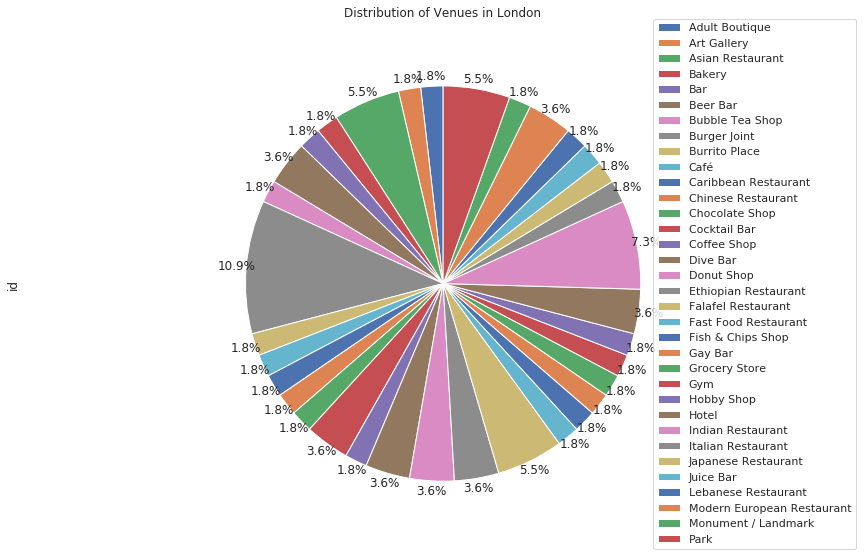

In [297]:
df_pie2 = nearby_venues.groupby('categories', axis=0).count()
df_pie2['id'].plot(kind='pie',
                            figsize=(15, 8),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=False,       # add shadow  
                             labels=None, 
                           pctdistance=1.05
                            )
p.title('Distribution of Venues in London', y=1.1)
p.axis('equal') # Sets the pie chart to look like a circle.
p.legend(labels=df_pie1.index, loc='right') 
p.show()

In [299]:
nearby_nothotel=nearby_venues[ (nearby_venues["categories"].str.contains('Hotel'))==False]
nearby_nothotel
nearby_nothotel.groupby('categories').mean()


,lat,lng,distance,rating
categories,,,,
BBQ Joint,51.521400,-0.109908,397.000000,0.0
Bar,51.518904,-0.102672,198.000000,0.0
Beer Bar,51.521091,-0.104264,332.333333,0.0
Breakfast Spot,51.523504,-0.104629,356.000000,0.0
Burrito Place,51.520551,-0.109418,345.000000,0.0
Café,51.520534,-0.099812,432.000000,0.0
Church,51.518631,-0.099890,366.000000,0.0
Coffee Shop,51.519573,-0.106187,358.500000,0.0
Coworking Space,51.518381,-0.110231,454.000000,0.0


In [300]:
## Non Hotel venues
nearby_nothotel=nearby_venues[ (nearby_venues["categories"].str.contains('Hotel'))==False]
nearby_nothotel

## Hotel Details
print("Hotel Venues (in competition) :\n", nearby_hotel["categories"].value_counts(),"\n")
print('{} Hotel venues were returned by Foursquare for the London location({},{}) .'.format(nearby_hotel.shape[0],round(hotel_lat,2),round(hotel_lng,2)))
print("\n\n Mean distance from proposed location: ", nearby_hotel.groupby('categories').mean())
print("\n\n Nearest distance from proposed location: ", nearby_hotel.groupby('categories').min())

Hotel Venues (in competition) :
 Hotel    3
Name: categories, dtype: int64 

3 Hotel venues were returned by Foursquare for the London location(51.52,-0.1) .


 Mean distance from proposed location:                    lat       lng    distance  rating
categories                                         
Hotel       51.521862 -0.103229  231.333333     0.0


 Nearest distance from proposed location:                           name        lat       lng  distance  \
categories                                                     
Hotel       The Rookery Hotel  51.520094 -0.103658       139   

                                  id  rating  
categories                                    
Hotel       4ac518b8f964a52063a120e3       0  


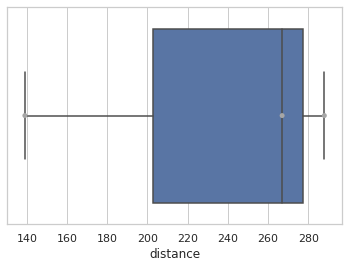

In [301]:
import seaborn as sns
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=nearby_hotel["distance"])
ax = sns.swarmplot(x=nearby_hotel["distance"], color=".65")

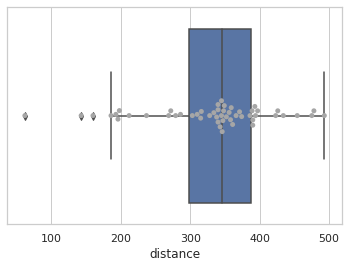

In [302]:
ax = sns.boxplot(x=nearby_nothotel["distance"])
ax = sns.swarmplot(x=nearby_nothotel["distance"], color=".65")

In [303]:
# create map of UK using latitude and longitude values
map_city= folium.Map(location=[hotel_lat, hotel_lng], zoom_start=15)

# add markers to map
for lat, lng,town, cat,dist in zip(nearby_hotel['lat'], nearby_hotel['lng'],nearby_hotel['name'], nearby_hotel['categories'], nearby_hotel['distance']):
    label = '{},{},{}'.format(cat,town,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city) 
    
## Others facilities Location
for lat, lng,town, cat,dist in zip(nearby_nothotel['lat'], nearby_nothotel['lng'],nearby_nothotel['name'], nearby_nothotel['categories'], nearby_nothotel['distance']):
    label = '{},{},{}'.format(cat,town,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city) 

## Planned Hotel Location
folium.CircleMarker(
    [hotel_lat, hotel_lng],
    radius=10,
    popup='Planned Hotel',
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_city)  
    
map_city

In [304]:
Location2_venues = getNearbyVenues(names=UKpostcode_df2['Town/Area'],
                                   latitudes=UKpostcode_df2['Latitude'],
                                   longitudes=UKpostcode_df2['Longitude']
                                  )
Location2_venues

St Bartholomew's Hospital
Broadgate, Liverpool Street
Old Broad Street, Tower 42
Bank of England
Guildhall
Barbican
St Mary Axe, Aldgate
Leadenhall, Lloyd's of London, Fenchurch Street
Monument, Billingsgate
Royal Exchange, Lombard Street
Fetter Lane
St Paul's
Mansion House
Cannon Street
Blackfriars
Temple


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category
0,St Bartholomew's Hospital,51.5203,-0.104446,Oriole,51.518904,-0.102672,198,Bar
1,St Bartholomew's Hospital,51.5203,-0.104446,Scotch Malt Whisky Society,51.519444,-0.106879,193,Whisky Bar
2,St Bartholomew's Hospital,51.5203,-0.104446,Jerusalem Tavern,51.521735,-0.104170,160,Pub
3,St Bartholomew's Hospital,51.5203,-0.104446,The Rookery Hotel,51.520094,-0.102464,139,Hotel
4,St Bartholomew's Hospital,51.5203,-0.104446,BrewDog Clerkenwell,51.522401,-0.103835,237,Beer Bar
...,...,...,...,...,...,...,...,...
1287,Temple,51.5137,-0.108858,Pret A Manger,51.517280,-0.109022,398,Sandwich Place
1288,Temple,51.5137,-0.108858,Boots,51.513249,-0.104211,325,Pharmacy
1289,Temple,51.5137,-0.108858,Costa Coffee,51.511192,-0.103452,467,Coffee Shop
1290,Temple,51.5137,-0.108858,Moi An,51.517208,-0.109209,391,Vietnamese Restaurant


In [166]:
print(Location2_venues.shape)
Location2_venues.head()

(1292, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category
0,St Bartholomew's Hospital,51.5203,-0.104446,Oriole,51.518904,-0.102672,198,Bar
1,St Bartholomew's Hospital,51.5203,-0.104446,Scotch Malt Whisky Society,51.519444,-0.106879,193,Whisky Bar
2,St Bartholomew's Hospital,51.5203,-0.104446,Jerusalem Tavern,51.521735,-0.104170,160,Pub
3,St Bartholomew's Hospital,51.5203,-0.104446,The Rookery Hotel,51.520094,-0.102464,139,Hotel
4,St Bartholomew's Hospital,51.5203,-0.104446,BrewDog Clerkenwell,51.522401,-0.103835,237,Beer Bar


In [305]:
LonNeighHotels=Location2_venues[Location2_venues["Venue Category"].str.contains('Hotel')==True]
print("The number hotel in Neighboring locations: ",LonNeighHotels.shape[0], " Percentage is ", round(LonNeighHotels.shape[0]/Location2_venues.shape[0]*100,2),"%")

The number hotel in Neighboring locations:  52  Percentage is  4.02 %


In [163]:
Location2_venues["GeoDistNV"]=0.0
Location2_venues["GeoDistVH"]=0.0
result21=[]
result22=[]
for label, row in Location2_venues.iterrows():
    OrigLat = row['Neighborhood Latitude']
    OrigLng = row['Neighborhood Longitude']
    DestLat = row['Venue Latitude']
    DestLng = row['Venue Longitude']
    Getdist = round(GeoDist(OrigLat, OrigLng ,DestLat,DestLng),2)
    result21.append(Getdist)
    Getdist = round(GeoDist(neighborhood_latitude, neighborhood_longitude ,DestLat,DestLng),2)
    result22.append(Getdist)

In [167]:
Location2_venues["GeoDistNV"]=result21
Location2_venues["GeoDistVH"]=result22

In [168]:
Location2_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category,GeoDistNV,GeoDistVH
0,St Bartholomew's Hospital,51.5203,-0.104446,Oriole,51.518904,-0.102672,198,Bar,0.12,0.12
1,St Bartholomew's Hospital,51.5203,-0.104446,Scotch Malt Whisky Society,51.519444,-0.106879,193,Whisky Bar,0.12,0.12
2,St Bartholomew's Hospital,51.5203,-0.104446,Jerusalem Tavern,51.521735,-0.104170,160,Pub,0.10,0.10
3,St Bartholomew's Hospital,51.5203,-0.104446,The Rookery Hotel,51.520094,-0.102464,139,Hotel,0.09,0.09
4,St Bartholomew's Hospital,51.5203,-0.104446,BrewDog Clerkenwell,51.522401,-0.103835,237,Beer Bar,0.15,0.15
...,...,...,...,...,...,...,...,...,...,...
1287,Temple,51.5137,-0.108858,Pret A Manger,51.517280,-0.109022,398,Sandwich Place,0.25,0.29
1288,Temple,51.5137,-0.108858,Boots,51.513249,-0.104211,325,Pharmacy,0.20,0.49
1289,Temple,51.5137,-0.108858,Costa Coffee,51.511192,-0.103452,467,Coffee Shop,0.29,0.63
1290,Temple,51.5137,-0.108858,Moi An,51.517208,-0.109209,391,Vietnamese Restaurant,0.24,0.30


In [169]:
Location2_venues.groupby('Neighborhood').mean()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,GeoDistNV,GeoDistVH
Neighborhood,,,,,,,
Bank of England,51.5163,-0.091868,51.515522,-0.091270,355.650000,0.220900,0.679400
Barbican,51.5200,-0.096344,51.520943,-0.094983,357.659091,0.222614,0.435568
Blackfriars,51.5126,-0.100243,51.513656,-0.099227,367.967742,0.228387,0.541452
"Broadgate, Liverpool Street",51.5184,-0.086829,51.517847,-0.085182,385.680851,0.239362,0.863191
Cannon Street,51.5114,-0.091751,51.512905,-0.093918,378.424242,0.235303,0.699242
Fetter Lane,51.5159,-0.108661,51.515895,-0.108920,293.160000,0.182300,0.392300
Guildhall,51.5158,-0.094928,51.514870,-0.094651,332.050000,0.206000,0.584900
"Leadenhall, Lloyd's of London, Fenchurch Street",51.5122,-0.083735,51.512456,-0.081280,365.461538,0.226923,1.141667
Mansion House,51.5134,-0.093102,51.513299,-0.093099,248.200000,0.154300,0.696800


In [170]:
Location2_venues.groupby('Venue Category').mean()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Distance,GeoDistNV,GeoDistVH
Venue Category,,,,,,,
American Restaurant,51.513750,-0.100408,51.513173,-0.101264,146.500000,0.090000,0.510000
Antique Shop,51.514800,-0.108759,51.517145,-0.112608,384.500000,0.240000,0.410000
Argentinian Restaurant,51.515150,-0.096753,51.513324,-0.097880,295.500000,0.185000,0.765000
Art Gallery,51.515675,-0.094475,51.517389,-0.094816,326.583333,0.203333,0.550833
Arts & Crafts Store,51.516000,-0.087486,51.511898,-0.084645,497.000000,0.310000,1.030000
...,...,...,...,...,...,...,...
Whisky Bar,51.518200,-0.099979,51.520071,-0.099477,321.333333,0.200000,0.363333
Wine Bar,51.515403,-0.097044,51.515603,-0.096351,348.800000,0.217429,0.545429
Wine Shop,51.516700,-0.084419,51.517335,-0.079857,398.000000,0.250000,1.080000


In [171]:
Location2_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Distance,Venue Category,GeoDistNV,GeoDistVH
Neighborhood,,,,,,,,,
Bank of England,100,100,100,100,100,100,100,100,100
Barbican,88,88,88,88,88,88,88,88,88
Blackfriars,62,62,62,62,62,62,62,62,62
"Broadgate, Liverpool Street",47,47,47,47,47,47,47,47,47
Cannon Street,66,66,66,66,66,66,66,66,66
Fetter Lane,100,100,100,100,100,100,100,100,100
Guildhall,100,100,100,100,100,100,100,100,100
"Leadenhall, Lloyd's of London, Fenchurch Street",78,78,78,78,78,78,78,78,78
Mansion House,100,100,100,100,100,100,100,100,100


In [172]:
print('There are {} uniques categories.'.format(len(Location2_venues['Venue Category'].unique())))

There are 140 uniques categories.


### Analysis of Each Neighborhood in London

#### One Hot coding

In [173]:
Location2_onehot = pd.get_dummies(Location2_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Location2_onehot['Neighborhood'] = Location2_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Location2_onehot.columns[-1]] + list(Location2_onehot.columns[:-1])
Location2_onehot = Location2_onehot[fixed_columns]

Location2_onehot.head()

,Neighborhood,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,St Bartholomew's Hospital,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,St Bartholomew's Hospital,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,St Bartholomew's Hospital,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,St Bartholomew's Hospital,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,St Bartholomew's Hospital,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
Location2_grouped = Location2_onehot.groupby('Neighborhood').mean().reset_index()
Location2_grouped

,Neighborhood,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Bank of England,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.000000,0.010000,0.000000,0.030000,0.000000,0.020000,0.000000,0.000000,0.020000
1,Barbican,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.011364,0.011364,0.000000,...,0.000000,0.022727,0.000000,0.000000,0.011364,0.000000,0.022727,0.000000,0.000000,0.000000
2,Blackfriars,0.016129,0.000000,0.000000,0.000000,0.000000,0.016129,0.000000,0.000000,0.032258,...,0.000000,0.016129,0.000000,0.000000,0.016129,0.000000,0.048387,0.000000,0.000000,0.000000
3,"Broadgate, Liverpool Street",0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.021277,0.021277,0.000000,0.000000
4,Cannon Street,0.000000,0.000000,0.000000,0.015152,0.000000,0.015152,0.000000,0.000000,0.000000,...,0.015152,0.000000,0.000000,0.000000,0.045455,0.000000,0.015152,0.000000,0.015152,0.015152
5,Fetter Lane,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,0.010000,0.040000,0.000000,0.000000,0.000000
6,Guildhall,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.000000,0.000000,0.010000,0.000000,0.020000,0.000000,0.030000,0.000000,0.010000,0.010000
7,"Leadenhall, Lloyd's of London, Fenchurch Street",0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.012821,0.000000,0.000000,...,0.012821,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Mansion House,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.000000,0.020000,...,0.000000,0.000000,0.010000,0.000000,0.020000,0.000000,0.040000,0.000000,0.000000,0.010000
9,"Monument, Billingsgate",0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.014706,0.000000,0.000000,...,0.014706,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [176]:
num_top_venues = 5

for hood in Location2_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Location2_grouped[Location2_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bank of England----
                  venue  freq
0           Coffee Shop  0.09
1  Gym / Fitness Center  0.04
2                 Hotel  0.03
3    Seafood Restaurant  0.03
4        Clothing Store  0.03


----Barbican----
                  venue  freq
0           Coffee Shop  0.08
1            Food Truck  0.08
2                  Café  0.06
3    Italian Restaurant  0.06
4  Gym / Fitness Center  0.03


----Blackfriars----
                venue  freq
0         Coffee Shop  0.11
1  Italian Restaurant  0.10
2                 Pub  0.06
3            Wine Bar  0.05
4              Bakery  0.03


----Broadgate, Liverpool Street----
                  venue  freq
0                 Hotel  0.09
1  Gym / Fitness Center  0.09
2            Food Truck  0.06
3            Boxing Gym  0.04
4      Sushi Restaurant  0.04


----Cannon Street----
                   venue  freq
0            Coffee Shop  0.09
1   Gym / Fitness Center  0.06
2  Vietnamese Restaurant  0.05
3         Clothing Store  0.05
4     Ital

In [177]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Location2_grouped['Neighborhood']

for ind in np.arange(Location2_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Location2_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bank of England,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Cocktail Bar,Hotel,Steakhouse,Seafood Restaurant,Clothing Store,Vietnamese Restaurant,Café
1,Barbican,Food Truck,Coffee Shop,Italian Restaurant,Café,French Restaurant,Gym / Fitness Center,Hotel,Sushi Restaurant,Indie Movie Theater,Concert Hall
2,Blackfriars,Coffee Shop,Italian Restaurant,Pub,Wine Bar,Gym / Fitness Center,Grocery Store,Falafel Restaurant,Sandwich Place,Salad Place,Bakery
3,"Broadgate, Liverpool Street",Gym / Fitness Center,Hotel,Food Truck,Boxing Gym,Sushi Restaurant,Italian Restaurant,Department Store,Chinese Restaurant,Restaurant,Pub
4,Cannon Street,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Clothing Store,Steakhouse,Vietnamese Restaurant,Japanese Restaurant,Roof Deck,English Restaurant,Cocktail Bar


## 4. Cluster Neighborhoods for Location 2
#### Using Kmeans to identify the different clusters

In [178]:
# set number of clusters
kclusters = 5

Location2_grouped_clustering = Location2_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Location2_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 0, 1, 3, 2, 1, 2, 4, 2, 4, 3, 2, 0, 3, 1, 1], dtype=int32)

In [179]:
UKpostcode_df2_2=UKpostcode_df2
UKpostcode_df2_2.rename(columns={'Town/Area':'Neighborhood'}, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [306]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Location2_merged = UKpostcode_df2_2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Location2_merged = Location2_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Location2_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

In [183]:
# create map of UK using latitude and longitude values
# create map
latitude=Location2_merged['Latitude'][0]
longitude=Location2_merged['Longitude'][0]
map_city= folium.Map(location=[hotel_lat, hotel_lng], zoom_start=15)

# add markers to map
for lat, lng,town, cat,dist in zip(nearby_hotel['lat'], nearby_hotel['lng'],nearby_hotel['name'], nearby_hotel['categories'], nearby_hotel['distance']):
    label = '{},{},{}'.format(cat,town,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city) 
    
## Others facilities Location
for lat, lng,town, cat,dist in zip(nearby_nothotel['lat'], nearby_nothotel['lng'],nearby_nothotel['name'], nearby_nothotel['categories'], nearby_nothotel['distance']):
    label = '{},{},{}'.format(cat,town,dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city) 

## Planned Hotel Location
folium.CircleMarker(
    [hotel_lat, hotel_lng],
    radius=10,
    popup='Planned Hotel',
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_city)  
    
map_city

In [186]:
import math
# create map
latitude=Location2_merged['Latitude'][0]
longitude=Location2_merged['Longitude'][0]

map_Location2_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Location2_merged['Latitude'], Location2_merged['Longitude'], Location2_merged['Neighborhood'], Location2_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if  not math.isnan(cluster):
        icluster=int(cluster)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            ##color=rainbow[cluster-1],
            color=rainbow[icluster-1],
            fill=True,
            ##fill_color=rainbow[cluster-1],
            fill_color=rainbow[icluster-1],
            fill_opacity=0.7).add_to(map_Location2_clusters)

        ## Planned Hotel Location
folium.CircleMarker(
    [hotel_lat, hotel_lng],
    radius=10,
    popup='Planned Hotel',
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.2,
    parse_html=False).add_to(map_Location2_clusters)  
    
map_Location2_clusters

### Merge for further analysis

In [155]:
MergedLocation = Location1_merged
MergedLocation = MergedLocation.append(Location2_merged, sort=False)

NameError: name 'Location2_merged' is not defined

In [65]:
MergedLocation

,Postcode,Neighborhood,Region,Latitude,Longitude,Nearby districts,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1,"Piccadilly, Northern Quarter, Manchester City ...",Manchester,53.4777,-2.236810,"M2, M60, M4, M61, M99, M3, M15, M13, M8, M14",12340.0,1,Gay Bar,Hotel,Coffee Shop,Indian Restaurant,Pub,Bar,Chinese Restaurant,Plaza,Cocktail Bar,Sushi Restaurant
1,M2,"Deansgate, Manchester City Centre",Manchester,53.4802,-2.244690,"M1, M3, M60, M4, M61, M99, M15, M8, M7, M5",88.0,1,Hotel,Italian Restaurant,Bar,Coffee Shop,Plaza,Sandwich Place,Café,Restaurant,Bookstore,Indian Restaurant
2,M3,"Manchester City Centre, Blackfriars, Trinity",Manchester,53.4835,-2.252180,"M2, M15, M60, M1, M4, M61, M99, M7, M8, M5",11844.0,1,Coffee Shop,Bar,Plaza,Pub,Restaurant,Hotel,Indian Restaurant,Grocery Store,Café,Italian Restaurant
3,M4,"Ancoats, Northern Quarter, Strangeways",Manchester,53.4848,-2.230700,"M61, M60, M99, M1, M2, M3, M8, M13, M15, M14",10675.0,1,Coffee Shop,Pub,Bar,Tea Room,Record Shop,Arts & Crafts Store,Beer Bar,Pizza Place,Cocktail Bar,Donut Shop
4,M8,"Crumpsall, Cheetham Hill",Manchester,53.5090,-2.240880,"M7, M60, M2, M61, M4, M99, M1, M3, M9, M10",30934.0,1,Grocery Store,Burger Joint,Tram Station,Asian Restaurant,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
5,M9,"Harpurhey, Blackley",Manchester,53.5217,-2.214390,"M8, M10, M40, M24, M99, M61, M4, M60, M13, M7",39434.0,1,Breakfast Spot,Bar,Construction & Landscaping,Pub,Pharmacy,Hotel,Garden Center,English Restaurant,Gay Bar,Convenience Store
6,M11,"Clayton, Openshaw, Beswick",Manchester,53.4784,-2.183290,"M18, M40, M10, M12, M43, M35, M13, M19, M99, M4",20281.0,2,Pub,Bakery,Business Service,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
7,M12,"Ardwick, Longsight, Chorlton-on-Medlock",Manchester,53.4656,-2.205520,"M13, M52, M11, M18, M19, M14, M1, M99, M4, M61",16377.0,1,Sports Club,Bus Stop,Sandwich Place,Korean Restaurant,Climbing Gym,Chinese Restaurant,Storage Facility,Construction & Landscaping,Bakery,Food Truck
8,M13,"Ardwick, Longsight, Chorlton-on-Medlock",Manchester,53.4622,-2.217150,"M52, M12, M14, M1, M99, M4, M61, M60, M15, M18",23642.0,1,Sports Club,Bus Stop,Sandwich Place,Korean Restaurant,Climbing Gym,Chinese Restaurant,Storage Facility,Construction & Landscaping,Bakery,Food Truck
9,M14,"Fallowfield, Moss Side, Ladybarn, Rusholme",Manchester,53.4469,-2.225040,"M52, M13, M20, M12, M19, M1, M99, M4, M61, M60",53136.0,1,Bus Station,Gym / Fitness Center,Park,Pub,Fried Chicken Joint,Racetrack,Music Venue,Coffee Shop,Electronics Store,Construction & Landscaping


In [68]:
OrigLat=51.5073219
OrigLng= -0.1276474
DestLat=51.5073219
DestLng= -0.1276474

In [74]:
print(GeoDist(OrigLat,OrigLng,DestLat,DestLng))

536.9979906964344


In [122]:
MergedLocation = Location2_merged
Location1_merged.dtypes

Postcode                   object
Neighborhood               object
Region                     object
Latitude                  float64
Longitude                 float64
Nearby districts           object
Population                float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [112]:
for label, row in MergedLocation.iterrows():
    ##print(row['Latitude'],row['Longitude'])
    OrigLat = row['Latitude']
    OrigLng = row['Longitude']
    DestLat=51.5073219
    DestLng= -0.1276474
    Getdist=(GeoDist(OrigLat, OrigLng ,DestLat,DestLng))
    ##print("Distance :", round(test,2))
    MergedLocation["GeoDistCalc"][label] = Getdist
    
##print(MergedLocation)
print("The overall mean distance is :",round(MergedLocation["GeoDistCalc"].mean(),2),"miles")

The overall mean distance is : 161.51 miles


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [111]:
MergedLocation

,Postcode,Neighborhood,Region,Latitude,Longitude,Nearby districts,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,GeoDistCalc
0,M1,"Piccadilly, Northern Quarter, Manchester City ...",Manchester,53.4777,-2.23681,"M2, M60, M4, M61, M99, M3, M15, M13, M8, M14",12340.0,1,Gay Bar,Hotel,Coffee Shop,Indian Restaurant,Pub,Bar,Chinese Restaurant,Plaza,Cocktail Bar,Sushi Restaurant,162.486232
1,M2,"Deansgate, Manchester City Centre",Manchester,53.4802,-2.24469,"M1, M3, M60, M4, M61, M99, M15, M8, M7, M5",88.0,1,Hotel,Italian Restaurant,Bar,Coffee Shop,Plaza,Sandwich Place,Café,Restaurant,Bookstore,Indian Restaurant,162.810528
2,M3,"Manchester City Centre, Blackfriars, Trinity",Manchester,53.4835,-2.25218,"M2, M15, M60, M1, M4, M61, M99, M7, M8, M5",11844.0,1,Coffee Shop,Bar,Plaza,Pub,Restaurant,Hotel,Indian Restaurant,Grocery Store,Café,Italian Restaurant,163.171825
3,M4,"Ancoats, Northern Quarter, Strangeways",Manchester,53.4848,-2.23070,"M61, M60, M99, M1, M2, M3, M8, M13, M15, M14",10675.0,1,Coffee Shop,Pub,Bar,Tea Room,Record Shop,Arts & Crafts Store,Beer Bar,Pizza Place,Cocktail Bar,Donut Shop,162.753725
4,M8,"Crumpsall, Cheetham Hill",Manchester,53.5090,-2.24088,"M7, M60, M2, M61, M4, M99, M1, M3, M9, M10",30934.0,1,Grocery Store,Burger Joint,Tram Station,Asian Restaurant,Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,164.377328
5,M9,"Harpurhey, Blackley",Manchester,53.5217,-2.21439,"M8, M10, M40, M24, M99, M61, M4, M60, M13, M7",39434.0,1,Breakfast Spot,Bar,Construction & Landscaping,Pub,Pharmacy,Hotel,Garden Center,English Restaurant,Gay Bar,Convenience Store,164.512910
6,M11,"Clayton, Openshaw, Beswick",Manchester,53.4784,-2.18329,"M18, M40, M10, M12, M43, M35, M13, M19, M99, M4",20281.0,2,Pub,Bakery,Business Service,Yoga Studio,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,161.309128
7,M12,"Ardwick, Longsight, Chorlton-on-Medlock",Manchester,53.4656,-2.20552,"M13, M52, M11, M18, M19, M14, M1, M99, M4, M61",16377.0,1,Sports Club,Bus Stop,Sandwich Place,Korean Restaurant,Climbing Gym,Chinese Restaurant,Storage Facility,Construction & Landscaping,Bakery,Food Truck,161.075478
8,M13,"Ardwick, Longsight, Chorlton-on-Medlock",Manchester,53.4622,-2.21715,"M52, M12, M14, M1, M99, M4, M61, M60, M15, M18",23642.0,1,Sports Club,Bus Stop,Sandwich Place,Korean Restaurant,Climbing Gym,Chinese Restaurant,Storage Facility,Construction & Landscaping,Bakery,Food Truck,161.146339
9,M14,"Fallowfield, Moss Side, Ladybarn, Rusholme",Manchester,53.4469,-2.22504,"M52, M13, M20, M12, M19, M1, M99, M4, M61, M60",53136.0,1,Bus Station,Gym / Fitness Center,Park,Pub,Fried Chicken Joint,Racetrack,Music Venue,Coffee Shop,Electronics Store,Construction & Landscaping,160.452209
